In [3]:
# import adagram
from allennlp.commands.elmo import ElmoEmbedder
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from tqdm.notebook import tqdm
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import *
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')
stops = set(stopwords.words('russian'))

def normalize_pm(text):
    words = [morph.parse(word)[0].normal_form for word in tokenize(text) if word]
    return words

def tokenize(text):
    return token.tokenize(text)

## Адаграм

Word2Vec и многие другие векторные модели сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. 

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопоставлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова.

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

In [ ]:
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

Посмотрим на значения каких-нибудь слов.

In [ ]:
vm.word_sense_probs('вечер')

Посмотрим какие слова близки к каждому из значений.

In [ ]:
vm.sense_neighbors('вечер', 0)

In [ ]:
vm.sense_neighbors('вечер', 1)

In [ ]:
vm.sense_neighbors('вечер', 2)

Можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [ ]:
ambiguous = []
for i, word in enumerate(vm.dictionary.id2word):
    probs = vm.word_sense_probs(word)
    if len(probs) > 1:
        ambiguous.append(word)
print(ambiguous[:50])

In [ ]:
means = vm.disambiguate('вечер', normalize_pm("Ради любви родителей, ради того, чтобы они снова также танцевали в их гостиной, наслаждаясь милыми семейными"))

In [ ]:
vm.sense_neighbors('вечер', np.argmax(means))

In [ ]:
means = vm.disambiguate('вечер', normalize_pm("абонемент № 19 \"Камерные \" включает в себя и концерт лауреата последнего Конкурса Чайковского"))

In [ ]:
vm.sense_neighbors('вечер', np.argmax(means))

## WSD / WSI
Разрешение семантической/лексической неоднозначности/омонимии

Проверим, насколько хорошо выбирается значение на данных с [соревнования Диалога](http://www.dialog-21.ru/evaluation/2018/disambiguation/) (переиспользую [baseline](https://github.com/nlpub/russe-wsi-kit) соревнования)

**NB!** Большая модель AdaGram для русского языка, которую мы используем, обучена на корпусе с нормализацией *mystem*. Так что немного модифицируем нашу функцию нормализации.

In [4]:
mystem = Mystem()

def disambiguate(model, word, context):
    word, _ = lemmatized_context(word)
    probs = model.disambiguate(word, lemmatized_context(context))
    return 1 + probs.argmax()


def lemmatized_context(s):
    return [w.lower() for w in mystem.lemmatize(" ".join(tokenize(s)))]


Installing mystem to C:\Users\Lenovo/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip


In [5]:
df = pd.read_csv('data/train.baseline-adagram.csv', sep='\t')

In [6]:
pd.set_option('display.max_colwidth', 1000)

In [7]:
df.head(5)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,1,"0-5, 339-344","замок владимира мономаха в любече . многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости . ранние европейские замки строились преимущественно из дерева они опоясывались деревянной оградой — палисадом уже тогда вокруг замков стали появляться рвы . примером такого замка может служить вышгородский замок киевских князей . каменное замковое строительство распространилось в западной и центральной европе лишь к xii веку . главной частью средневекового замка являлась центральная башня — донжон , выполнявшая функции цитадели . помимо своих оборонительных функций , донжон являлся непосредственным жилищем феодала . также в главной башне"
1,2,замок,1,1,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный в русскоязычной литературе как шильо́нский за́мок , расположен на швейцарской ривьере , у кромки женевского озера , в км от города монтре . замок представляет собой комплекс из элементов разного времени постройки ."
2,3,замок,1,1,299-304,"проведения архитектурно - археологических работ эстонским реставрационным управлением под руководством архитектора х . и . потти , искусствоведа е . а . кальюнди и при научной консультации доктора исторических наук п . а . рапопорта . с года музей называется государственным музеем выборгский замок ."
3,4,замок,1,1,111-116,"топи с . , л . белокуров легенда о завещании мавра с . , н . юсупов день рождения с . , р . янушкевич янтарный замок с . ."
4,5,замок,1,1,"134-139, 262-267","великий князь литовский гедимин после успешной охоты обнаружил прекрасное место недалеко от города кернаве , решил воздвигнуть на нем замок и перенести сюда столицу . во второй половине xiv века здесь , в старых троках ( "" сянейи тракай "" ) , уже стоял каменный замок . правил им в — сын гедимина трокский князь кейстут . около года в этом замке родился витовт . в году кейстут перенес свою столицу из старых трок"


In [8]:
df['predict_sense_id'] = [disambiguate(vm, word, context)
                          for word, context in tqdm(zip(df['word'], df['context']), total=len(df))]

NameError: name 'vm' is not defined

In [ ]:
per_word = df.groupby('word').apply(lambda f: adjusted_rand_score(f['gold_sense_id'], f['predict_sense_id'])).to_frame('ARI')
per_word_ari = per_word['ARI']
print('Mean word ARI: %.4f' % np.mean(per_word_ari))

In [ ]:
per_word

В качестве метрики используется [Adjuster Rand Index](https://en.wikipedia.org/wiki/Rand_index), а [вот ссылка на документацию](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

## Contextualized embeddings
[ELMo](https://arxiv.org/pdf/1802.05365.pdf) — модель, которая позволяет получить не просто вектор слова W,
а _вектор слова W в контексте C_.
Что происходит?
Обучаем двунаправленную (bidirectional) языковую модель примерно так*:

<img src="https://jalammar.github.io/images/Bert-language-modeling.png" alt="elmo" width="400"/>

Но затем мы не просто берем какие-то представления отдельных слов, а сохраняем все веса и пропускаем каждое 
предложение для новой задачи через такую сетку с этими весами. Получаем вектора для всех слов в предложении из нескольких слоев!

\* картинка из [блога](https://jalammar.github.io/) чувака по имени Jay Allamar, кстати, очень доступные объяснения всяких NLP-штук с картинками

In [23]:
# Немножко кода для загрузки модели
class Elmo:
    def __init__(self, path=""):
        if path:
            self.elmo = ElmoEmbedder(options_file=path + "/options.json", weight_file=path + "/model.hdf5")
        else:
            self.elmo = ElmoEmbedder()

    def get_elmo_vector(self, tokens, layer):
        vectors = self.elmo.embed_sentence(tokens)
        X = []
        for vector in vectors[layer]:
            X.append(vector)

        X = np.array(X)

        return X
    
    def get_word_vector(self, word, tokens, layer):
        vectors = self.elmo.embed_sentence(tokens)
        for v, t in zip(vectors[layer], tokens):
            if t == word:
                return v

In [24]:
model = Elmo("196")

In [25]:
sentence = "многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости"
tokens = normalize_pm(sentence)
v = model.get_elmo_vector(tokens, 0)
print(tokens)
print(v.shape)

['многочисленный', 'укрепить', 'монастырь', 'также', 'не', 'являться', 'замок', 'как', 'таковой', 'это', 'быть', 'крепость']
(12, 1024)


In [26]:
print(model.get_word_vector('замок', tokens, 2))

[ 0.6661943  -0.5810346  -0.37284237 ... -1.6235733  -0.61625093
  0.2799521 ]


Попробуем сначала нарисовать, что получается (пропустим немного заранее заготовленной магии matplotlib и PCA)

In [27]:
def dim_reduction(X, n):
    pca = PCA(n_components=n)
    print("size of X: {}".format(X.shape))
    results = pca.fit_transform(X)
    print("size of reduced X: {}".format(results.shape))

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print("Variance retained ratio of PCA-{}: {}".format(i+1, ratio))

    return results

In [51]:
def plot(word, token_list, labels, reduced_X):
    fig, ax = plt.subplots()
    colors = ['ro', 'bo', 'yo', 'go', 'co']
    label_color = {}
    for i, l in enumerate(set(labels)):
        label_color[l] = colors[i]

    i = 0
    points = []
    for j, (tokens, l) in enumerate(zip(token_list, labels)):
        color = label_color[l[0]]
        for k, w in enumerate(tokens):
            if w == word:
                ax.plot(reduced_X[i, 0], reduced_X[i, 1], color)
                points.append((j, k, reduced_X[i, 0], reduced_X[i, 1]))
            i += 1

    for p in points:
        s = token_list[p[0]]
        text = ' '.join(s[max(0, p[1] - 5):min(p[1] + 5, len(s))])

        # bold the word of interest in the sentence
        text = text.replace(word, r"$\bf{" + word + "}$")

        plt.annotate(text, xy=p[2:])
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

In [29]:
df = pd.read_csv('data/train.csv', sep='\t')

In [30]:
df[df['word'] == 'замок']

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344","замок владимира мономаха в любече . многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости . ранние европейские замки строились преимущественно из дерева они опоясывались деревянной оградой — палисадом уже тогда вокруг замков стали появляться рвы . примером такого замка может служить вышгородский замок киевских князей . каменное замковое строительство распространилось в западной и центральной европе лишь к xii веку . главной частью средневекового замка являлась центральная башня — донжон , выполнявшая функции цитадели . помимо своих оборонительных функций , донжон являлся непосредственным жилищем феодала . также в главной башне"
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный в русскоязычной литературе как шильо́нский за́мок , расположен на швейцарской ривьере , у кромки женевского озера , в км от города монтре . замок представляет собой комплекс из элементов разного времени постройки ."
2,3,замок,1,NaN,299-304,"проведения архитектурно - археологических работ эстонским реставрационным управлением под руководством архитектора х . и . потти , искусствоведа е . а . кальюнди и при научной консультации доктора исторических наук п . а . рапопорта . с года музей называется государственным музеем выборгский замок ."
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании мавра с . , н . юсупов день рождения с . , р . янушкевич янтарный замок с . ."
4,5,замок,1,NaN,"134-139, 262-267","великий князь литовский гедимин после успешной охоты обнаружил прекрасное место недалеко от города кернаве , решил воздвигнуть на нем замок и перенести сюда столицу . во второй половине xiv века здесь , в старых троках ( "" сянейи тракай "" ) , уже стоял каменный замок . правил им в — сын гедимина трокский князь кейстут . около года в этом замке родился витовт . в году кейстут перенес свою столицу из старых трок"
...,...,...,...,...,...,...
133,134,замок,2,NaN,292-297,"с корпусом из дуба , вяза и других твердых пород дерева , усиленных просечными металлическими накладками и крепящимися к дверному полотну с помощью фигурных скоб . существовало два основных типа замка . первый известен как старонемецкий , в нем засов заканчивался скошенной площадкой . такой замок защелкивался при захлопывании двери , но требовал металлическую приемную планку на откосе . для отпирания ключ вставляли в замочную скважину замка и разворачивали на — ° . при этом бородка ключа смещала засов внутрь корпуса . во время движения засов задней"
134,135,замок,2,NaN,223-228,"ключ в таком замке не имел бородки в привычном понимании — это был цилиндр , на конце которого прорезаны продольные пазы разной длины . в г . англичане братья джереми и чарльз чебб ( chubb ) получили патент на детекторный замок , который принято считать базовым для современных сувальдных систем . прологом настоящей революции стал г . , когда американский изобретатель линус йейл - старший ( linus yale sr . ) запатентовал конструкцию , в которой использовал принцип древнеегипетского"
135,136,замок,2,NaN,"140-145, 168-173","бизнесмен из российского города павлово ( на оке ) . размеры замка высота м см , ширина м см , толщина см . вес замка с ключом , кг , ( замок , кг , ключ , кг ) . замок был зарегистрирован в книге рекордов россии и книге рекордов гиннеса . говорят , что если повернуть ключ , то играет мелодия на семи холмах — гимн"
136,137,замок,2,NaN,"64-69, 265-270",") творчески переработал наработки отца и запатентовал штифтовой замок с маленьким плоским ключом , ставший наиболее распространенным замком хх века . отдельным видом замков стали сейфовые системы . в г . вильям русерфорд ( william rutherford ) запатентовал первый замок с часовым механизмом . изобретатель поставил в тыльный конец ригеля круглую пластину , которая препятствовала передвижению засова ключом , пока пластина ( вращаемая часовым механизмом ) не становил

In [31]:
sentences_1 = df[df['word']=='замок'][df['gold_sense_id']=='1'].sample(4, random_state=5)
sentences_2 = df[df['word']=='замок'][df['gold_sense_id']=='2'].sample(4, random_state=5)

In [32]:
sentences = list(sentences_1['context']) + list(sentences_2['context'])
labels = list(sentences_1['gold_sense_id']) + list(sentences_2['gold_sense_id'])

In [33]:
sentences

['стоит замок , словно специально был создан для того , чтобы данноттар стал самой неприступной крепостью шотландии . в замок можно было попасть всего двумя способами через хорошо укрытый в расселине скалы главный вход либо по узкой крутой тропинке , которая вела через пещеры к потайному входу в замок . неудивительно , что в течение многих веков на неприступной скале возводили укрепления . известно , что название замка произошло от пиктского слова " dun " , а в конце v в . в эти земли прибыл святой ниниан , чтобы обратить пиктов в',
 'новопостроенные замки часто стилизировались под средневековые , однако не имели никакого оборонительного значения — стены и башни этих замков , порой весьма внушительные , служили лишь декоративным целям . характерными примерами подобного типа замков являются замки , построенные королем людвигом ii баварским в середине xix века ( в особенности — замок нойшванштайн ) .',
 'его завоевать . островной замок сразу стал основной резиденцией великого князя витов

In [34]:
X = np.concatenate(
    [model.get_elmo_vector(tokens=normalize_pm(sentences[idx]), layer=2) for idx, _ in enumerate(sentences)], axis=0
)

In [35]:
X.shape

(533, 1024)

In [36]:
X_reduce = dim_reduction(X=X, n=2)

size of X: (533, 1024)
size of reduced X: (533, 2)
Variance retained ratio of PCA-1: 0.08219816535711288
Variance retained ratio of PCA-2: 0.050151702016592026


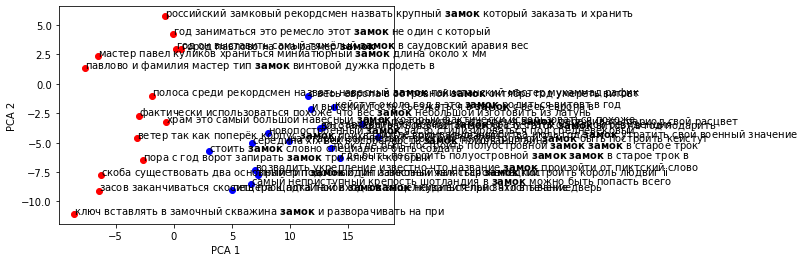

In [52]:
plot('замок', [normalize_pm(s) for s in sentences],  labels, X_reduce)

Что можно сделать с этими векторами в целях WSD?
* классификатор
* кластеризация

Попробуем разные методы кластеризации.

In [54]:
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [ ]:
ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].apply(normalize_pm)
    labels = grouped_df.get_group(key)['gold_sense_id'].to_list()
    X = []
    gold_labels = []
    
    for i, text in enumerate(texts):
        v = model.get_word_vector(key, text, 2)
        if v is not None:
            X.append(v)
            gold_labels.append(labels[i])

    if not X:
        continue
    cluster = AffinityPropagation(damping=0.9)
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1
    
    ARI.append(adjusted_rand_score(gold_labels, labels))
    
    print(key, '  ', adjusted_rand_score(gold_labels, labels))
print(np.mean(ARI))

балка    0.0753073421060269
бор    0.0
вид    0.0
дар    0.02730202227804422
двигатель    0.0
двойник    -0.006757688594676574
дворец    0.1825557809330629
девятка    0.08180872486424066
дедушка    0.35294117647058826
дежурный    -0.08553971486761708
декабрист    0.1965471447543161
декрет    0.5378151260504201
дело    0.11065794805472308
демобилизация    0.39378238341968913
демократ    0.10088148873653283
демонстрация    0.0
дерево    0.06324110671936758
держава    0.0
дерзость    0.02821394392655869
десятка    0.04833836858006042
десяток    1.0
деятель    0.506896551724138
диалог    0.40492957746478875
диаметр    -0.01900097943192947
диплом    0.09793814432989689
директор    -0.022576361221779515
диск    0.08696851751490368
дичь    -0.015460295151089279
длина    -0.06497622820919173
доброволец    -0.054794520547945265
добыча    0.1847442192965286
доказательство    -0.0029960053262317386
доктор    0.0
долгота    0.0
доля    0.29692892953417477
дом    0.0
дорога    0.15827679425296878
д